# **<center>IMDB | Predicting the Success of a Film Using Historical Data | Sharpest Minds<center>**

## Data
**Dataset(s):**

- IMDb - https://datasets.imdbws.com/
- OMDb API - http://www.omdbapi.com/
- OpusData - https://www.opusdata.com/home.php
- TMDb - https://www.themoviedb.org/documentation/api

## **<center>Data Dictionary<center>**
Please refer to the online data dictionary documentation for the IMDb dataset: https://bigspans.com/wp-content/uploads/2020/10/Documentation-Data-Dictionary-IMDb-and-Box-Office-Mojo.pdf
    
       
## **<center>Problem Statement:<center>**

### **<center>How can we predict the success of a film using historical data?<center>**
<br>
    
<br>

## **<center>Goal(s):<center>**
    
**Define Success:**
- 1. Gross Reveue (Profits)
- 2. Rating
- 3. Award nomimations and wins

**What departments, jobs, or individuals have the most effect on determining the success of a film?**
    
**What are the most successful: ?**
- 1. Genres
- 2. Studios (Independent, Mainstream, etc.)
- 3. Production Companies
- 4. Locations
- 5. N/A



## **<center>Index:<center>**
**1. Loading and merging datasets**

**2. Cleaning**

**3. EDA**

**4. Modeling**

**5. Findings & Summary**

## **<center>Field(s) of Interest:<center>**

### Target Variables:

1. **Revenue** - (Continuous Variable)
2. **Rating** - (Continuous Variable)

### Predictive Problem Type:
1. Regression
2. Classification (blockbuster or flop)
    
*note: Classification is the task of predicting a discrete class label. Regression is the task of predicting a continuous quantity.*

### Predictive Algorithms:

1. Linear Regression
2. Random Forests
3. XGBoost


In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
from ast import literal_eval
from typing import Dict, List
from collections import Counter
import ast
import re
import json
import nltk
import re
import csv
import math
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

%matplotlib inline

import warnings; warnings.simplefilter('ignore')

# 1. Load & Merge Data

In [128]:
col_list = ["id", "imdb_id", "title", "budget", "revenue",
            "release_date", "genres", "belongs_to_collection", "production_companies",
            "production_countries", "runtime"]

imdb_metadata = pd.read_csv('../data/raw/movies_metadata.csv', usecols=col_list)
imdb_credits = pd.read_csv('../data/raw/credits.csv')
imdb_ratings = pd.read_csv('../data/raw/ratings.csv')

## Metadata

In [129]:
imdb_metadata = imdb_metadata[["id", "imdb_id", "title", "budget", "revenue",
            "release_date", "genres", "belongs_to_collection", "production_companies",
            "production_countries", "runtime"]].copy()

In [130]:
imdb_metadata.head()

,id,imdb_id,title,budget,revenue,release_date,genres,belongs_to_collection,production_companies,production_countries,runtime
0,862,tt0114709,Toy Story,30000000,373554033.0,1995-10-30,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","{'id': 10194, 'name': 'Toy Story Collection', ...","[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",81.0
1,8844,tt0113497,Jumanji,65000000,262797249.0,1995-12-15,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",104.0
2,15602,tt0113228,Grumpier Old Men,0,0.0,1995-12-22,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","{'id': 119050, 'name': 'Grumpy Old Men Collect...","[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",101.0
3,31357,tt0114885,Waiting to Exhale,16000000,81452156.0,1995-12-22,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",127.0
4,11862,tt0113041,Father of the Bride Part II,0,76578911.0,1995-02-10,"[{'id': 35, 'name': 'Comedy'}]","{'id': 96871, 'name': 'Father of the Bride Col...","[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",106.0


Dataframe Size and Shape

In [131]:
imdb_metadata.shape

(45466, 11)

**45,466 rows and 11 features**

Features & Data Types

In [132]:
imdb_metadata.dtypes

id                        object
imdb_id                   object
title                     object
budget                    object
revenue                  float64
release_date              object
genres                    object
belongs_to_collection     object
production_companies      object
production_countries      object
runtime                  float64
dtype: object

**To Do:** Extract the nested list of dictionaries from the `belongs_to_collection`, `production_companies`, and `production_countries`

## Credits

I want to also include the `Cast` and `Crew` as a feature, but these instances are nested. I will extract the relevant column(s) and transform it into a workable format.

In [133]:
imdb_credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


Columns and Data Types

In [134]:
imdb_credits.dtypes

cast    object
crew    object
id       int64
dtype: object

Use a for loop to separate out the relevant elements.

In [135]:
cast_df = []
crew_df = []

for i in range(imdb_credits.shape[0]):
    cast = eval(imdb_credits['cast'][i])
    for x in cast:
        x['id'] = imdb_credits['id'][i]
    crew = eval(imdb_credits['crew'][i])
    for x in crew:
        x['id'] = imdb_credits['id'][i]
    cast_df.extend(cast)
    crew_df.extend(crew)

cast_df = pd.DataFrame(cast_df)
crew_df = pd.DataFrame(crew_df)

In [136]:
crew_df.head()

,credit_id,department,gender,id,job,name,profile_path
0,52fe4284c3a36847f8024f49,Directing,2,862,Director,John Lasseter,/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg
1,52fe4284c3a36847f8024f4f,Writing,2,862,Screenplay,Joss Whedon,/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg
2,52fe4284c3a36847f8024f55,Writing,2,862,Screenplay,Andrew Stanton,/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg
3,52fe4284c3a36847f8024f5b,Writing,2,862,Screenplay,Joel Cohen,/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg
4,52fe4284c3a36847f8024f61,Writing,0,862,Screenplay,Alec Sokolow,/v79vlRYi94BZUQnkkyznbGUZLjT.jpg


In [137]:
crew_df.shape

(464314, 7)

In [138]:
cast_df.head()

,cast_id,character,credit_id,gender,id,name,order,profile_path
0,14,Woody (voice),52fe4284c3a36847f8024f95,2,862,Tom Hanks,0,/pQFoyx7rp09CJTAb932F2g8Nlho.jpg
1,15,Buzz Lightyear (voice),52fe4284c3a36847f8024f99,2,862,Tim Allen,1,/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg
2,16,Mr. Potato Head (voice),52fe4284c3a36847f8024f9d,2,862,Don Rickles,2,/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg
3,17,Slinky Dog (voice),52fe4284c3a36847f8024fa1,2,862,Jim Varney,3,/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg
4,18,Rex (voice),52fe4284c3a36847f8024fa5,2,862,Wallace Shawn,4,/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg


In [139]:
cast_df.shape

(562474, 8)

There is a difference in size for both of these dataframes. It would be interesting to look at the Crew to Cast ratios... Not sure what could be done with that information just yet... It could potentially help production(s) find the sweet spot for how much "people-power" you need for a scene(s) - based on location (interior vs. exterior) (i.e. exterior locations need more people to control the enviroment (lock-ups)).

**Export cast and crew dataframes for further analysis related to genres, etc...**

In [140]:
# Save new dataframe as csv file to processed
cast_df.to_csv (('../data/processed/cast_df.csv'), index = False, header=True)
crew_df.to_csv (('../data/processed/crew_df.csv'), index = False, header=True)

## Ratings

In [141]:
imdb_ratings.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [142]:
imdb_ratings.shape

(26024289, 4)

The ratings dataset seems to contain each singular review that has been casted for a film. So in total there are 26,024,289 reviews for all of the films within this dataset. To validate this hypothesis, I will do a value count for each unique `movieId`

The total movies that have been rated are well within range of what is to be expected for movie id totals.

## **Summary**

The key dataset(s) to be used for further analysis and prediction are `imdb_metadata`, `imdb_credits`, and `imdb_ratings`. The **metadata** will be used as ***independent variables (i.e. genre, budget, revenue, etc.)***, the **credits** will be ***dependent variables***, and the **ratings** will be merged with additional ratings data (Rotten Tamotes, MetaCritic, etc.), which will be scaled (1-10 scale?), and then combined with the *independent variables* for a more conclusive analysis.

# 2. Data Cleaning & Preparation

## Data Quality

**Questions to keep in mind for preprocessing:**
1. What are the distributions of the key features?
2. How many missing values are there? *(blank, np.NaN, etc.)*
3. How missing values be handled?
4. Are there outliers?
5. Are any input values highly correlated?
6. What features exist in the input data and which features should be engineered?
7. Is there enough data?
8. How can we augment the dataset?
9. Is there bias in the dataset?
10. Formatting - is our data presented in a way that makes sense?  Are the variable types correct?
11. Validity - Are there any values that seem incorrect/nonsensical?

**Visualizations:**
1. Density plots and histograms to understand the spread of different input values.
2. Box plots to identify outliers.
3. Scatter plots to discover and describe bivariate relationships.
4. Percentiles to identify the range for numeric data.
5. Averages, medians, and standard deviations to describe central tendency.

Techniques and other to help help determine which features are likely to benefit the model as well as futher understanding of which data transformations will be needed to prepare the data for modeling.

Within the discovery stage, it can be helpful to do a few modeling experiments to see if there really is "signal in the noise."
- It could be beneficial to perform a machine learning feasibility study.

## Metadata

**To Do:**

*Pandas attempts to automatically infer the appropriate data types for columns. However its not uncommon to see it import a numerical column in as strings due to some quirk.*

**1. Drop films that do not meet a 1 mil+ revenue**

**2. Set up the right dtypes**
> - `budget`
> - `Id`
> - `release_date`

**3. Handle Missing Values and Duplicates**

**4. Drop Features**
> - `adult`
> - `homepage`
> - *`original_title`?* *(could be useful: i.e. anime title has huge following - but the studio changed the title for U.S.A market and lost big portion of original following)*
> - `overview`
> - `popularity`
> - `status`
> - `tagline`
> - `video`
> - `poster_path`

**5. UpperCase text variables for inconsistencies, anomolies, and duplicates**

**6. Dummifying the belongs_to_collection column.**



### Drop Films < 1 Mil USD

In [143]:
# First filter out those rows which
# does not contain any data
imdb_metadata = imdb_metadata.dropna(how = 'all')
  
# Filter all rows for which the film
# revenue is greater than or equal to 1 million USD
imdb_metadata.drop(imdb_metadata[imdb_metadata['revenue'] < 1000000].index, inplace = True)
imdb_metadata.head()

,id,imdb_id,title,budget,revenue,release_date,genres,belongs_to_collection,production_companies,production_countries,runtime
0,862,tt0114709,Toy Story,30000000,373554033.0,1995-10-30,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","{'id': 10194, 'name': 'Toy Story Collection', ...","[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",81.0
1,8844,tt0113497,Jumanji,65000000,262797249.0,1995-12-15,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",104.0
3,31357,tt0114885,Waiting to Exhale,16000000,81452156.0,1995-12-22,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",127.0
4,11862,tt0113041,Father of the Bride Part II,0,76578911.0,1995-02-10,"[{'id': 35, 'name': 'Comedy'}]","{'id': 96871, 'name': 'Father of the Bride Col...","[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",106.0
5,949,tt0113277,Heat,60000000,187436818.0,1995-12-15,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",170.0


In [144]:
imdb_metadata.shape

(6069, 11)

The dataset went from **45,466** rows to **6,069** rows. 

### Convert dtypes

**Features to convert**
- `budget` - Convert to a **numerical(int)** datatype
- `revenue` - Convert to a **numerical(int)** datatype
- `id` - Convert to a **numerical(int)** datatype
- `runtime` - Convert to a **numerical(int)** datatype
- `release_date` - Convert to a **Datetime** datatype

**`budget`, `id`, `imdb_id` converted to float**

`infer_objects` - Version 0.21.0 of pandas introduced the method infer_objects() for converting columns of a DataFrame that have an object datatype to a more specific type (soft conversions).

In [145]:
# Convert objects to int, float, or datetime
imdb_metadata = imdb_metadata.infer_objects()

**`id` converted to int**

In [146]:
print(imdb_metadata[imdb_metadata['id'].isnull()])

Empty DataFrame
Columns: [id, imdb_id, title, budget, revenue, release_date, genres, belongs_to_collection, production_companies, production_countries, runtime]
Index: []


In [147]:
imdb_metadata['id'] = pd.to_numeric(imdb_metadata['id'], errors='coerce')

In [148]:
imdb_metadata = imdb_metadata.dropna(subset=['id'])

In [149]:
imdb_metadata['id'] = imdb_metadata['id'].astype(int)

**`budget` converted to int**

In [150]:
print(imdb_metadata[imdb_metadata['budget'].isnull()])

Empty DataFrame
Columns: [id, imdb_id, title, budget, revenue, release_date, genres, belongs_to_collection, production_companies, production_countries, runtime]
Index: []


In [151]:
imdb_metadata['budget'] = pd.to_numeric(imdb_metadata['budget'], errors='coerce')

In [152]:
imdb_metadata = imdb_metadata.dropna(subset=['budget'])

In [153]:
imdb_metadata['budget'] = imdb_metadata['budget'].astype(int)

**`revenue` converted to int**

In [154]:
print(imdb_metadata[imdb_metadata['revenue'].isnull()])

           id    imdb_id title  budget  revenue release_date  \
19729   82663  tt0113002   NaN       0      NaN          NaN   
29502  122662  tt2423504   NaN       0      NaN          NaN   
35586  249260  tt2622826   NaN       0      NaN          NaN   

                                                  genres  \
19729  [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   
29502  [{'id': 16, 'name': 'Animation'}, {'id': 878, ...   
35586  [{'id': 10770, 'name': 'TV Movie'}, {'id': 28,...   

                                   belongs_to_collection production_companies  \
19729                                                NaN                  NaN   
29502  {'id': 122661, 'name': 'Mardock Scramble Colle...                  NaN   
35586                                                NaN                  NaN   

      production_countries  runtime  
19729                  NaN      NaN  
29502                  NaN      NaN  
35586                  NaN      NaN  


In [155]:
imdb_metadata['revenue'] = pd.to_numeric(imdb_metadata['revenue'], errors='coerce')

In [156]:
imdb_metadata = imdb_metadata.dropna(subset=['revenue'])

In [157]:
imdb_metadata['revenue'] = imdb_metadata['revenue'].astype(int)

**`release_date` converted to datetime**

In [158]:
imdb_metadata['release_date'] = pd.to_datetime(imdb_metadata['release_date'],  errors='coerce')

**SUMMARY**

In [159]:
imdb_metadata.dtypes

id                                int64
imdb_id                          object
title                            object
budget                            int64
revenue                           int64
release_date             datetime64[ns]
genres                           object
belongs_to_collection            object
production_companies             object
production_countries             object
runtime                         float64
dtype: object

### Missing Nan Values

In [160]:
imdb_missing = imdb_metadata.isna()
imdb_missing.head()

,id,imdb_id,title,budget,revenue,release_date,genres,belongs_to_collection,production_companies,production_countries,runtime
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,True,False,False,False


In [161]:
#  Calculate the missing fraction using basic arithmatic
percent_missing = imdb_metadata.isnull().sum() * 100 / len(imdb_metadata)
missing_value_df = pd.DataFrame({'column_name': imdb_metadata.columns,
                                 'percent_missing': percent_missing})

In [162]:
missing_value_df

,column_name,percent_missing
id,id,0.000000
imdb_id,imdb_id,0.000000
title,title,0.000000
budget,budget,0.000000
revenue,revenue,0.000000
release_date,release_date,0.000000
genres,genres,0.000000
belongs_to_collection,belongs_to_collection,76.991588
production_companies,production_companies,0.000000
production_countries,production_countries,0.000000


Roughly **73%** of films belong to a collection. *(i.e. Marvel, Starwars, Indians Jones, James Bond 007, etc...)*. 

*It will be nice to see the gross revenue for films that belong to a collection vs. those that do not... Are viewers more prone to invest time and money into franchise films? And if so, Why? Do they enjoy having something to look forward to in the next film? Is it just a scaled up version of television series?* 

### Missing '0' Values

In [163]:
def highlight(s):
    if s.percent_missing > 25:
        return ['background-color: yellow']*1
    else:
        
        return ['background-color: white']*1

In [164]:
percent_missing_values = imdb_metadata[imdb_metadata == '0'].count(axis=0) * 100 / len(imdb_metadata)
missing_values = pd.DataFrame({'percent_missing': percent_missing_values})

In [165]:
missing_values.style.apply(highlight, axis=1)

,percent_missing
id,0.000000
imdb_id,0.000000
title,0.000000
budget,0.000000
revenue,0.000000
release_date,0.000000
genres,0.000000
belongs_to_collection,0.000000
production_companies,0.000000
production_countries,0.000000


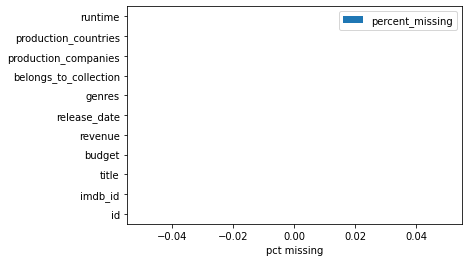

In [166]:
# plot the misssing values
missing_values.plot(kind="barh")# histogram
plt.xlabel("pct missing");# label missing categories

### **Genre(s)**

1. Extract genre names
2. Merge with `imdb_metadata`

I want to also include the movie genre as a feature, but this is nested. I will extract the relevant column and transform it into a workable format. Since movies can belong to one genre, I will have to take this into account by creating a `tmp` column which will as an indicator as to whether that movie belongs to that genre - this will come in handy later.

In [167]:
genres_df = imdb_metadata[['id', 'genres']]

In [168]:
genres_df.shape

(6063, 2)

In [169]:
dict_columns = ['genres']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

genres_df = text_to_dict(genres_df)

In [170]:
genres_df.shape

(6063, 2)

In [171]:
print('Number of genres in films')
genres_df['genres'].apply(lambda x: len(x) if x != {} else 0).value_counts()

Number of genres in films


3    1912
2    1874
1    1093
4     869
5     255
6      46
0      11
7       2
8       1
Name: genres, dtype: int64

**Most Common Genres** 

Generate a list of genres

In [172]:
# Extract list of genres
list_of_genres = list(genres_df['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

Total count of genres

In [173]:
Counter([i for j in list_of_genres for i in j]).most_common()

[('Drama', 2879),
 ('Comedy', 2194),
 ('Thriller', 1609),
 ('Action', 1573),
 ('Romance', 1177),
 ('Adventure', 1055),
 ('Crime', 938),
 ('Science Fiction', 666),
 ('Family', 631),
 ('Horror', 602),
 ('Fantasy', 575),
 ('Mystery', 481),
 ('Animation', 350),
 ('History', 249),
 ('Music', 219),
 ('War', 207),
 ('Western', 103),
 ('Documentary', 80),
 ('Foreign', 37),
 ('TV Movie', 1)]

The cutoff for `genres` is going to be `foreign` anything after that looks to be a non-genre. The top genre limit will be **20** which stops at 'TV Movie'.

Assign 1 or 0 to a genre

In [174]:
genres_df['num_genres'] = genres_df['genres'].apply(lambda x: len(x) if x != {} else 0)
genres_df['all_genres'] = genres_df['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(20)]
for g in top_genres:
    genres_df['genre_' + g] = genres_df['all_genres'].apply(lambda x: 1 if g in x else 0)
    
genres_df = genres_df.drop(['genres'], axis=1)

In [175]:
genres_df.head()

,id,num_genres,all_genres,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Adventure,genre_Crime,...,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,genre_War,genre_Western,genre_Documentary,genre_Foreign,genre_TV Movie
0,862,3,Animation Comedy Family,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,8844,3,Adventure Family Fantasy,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,31357,3,Comedy Drama Romance,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11862,1,Comedy,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,949,4,Action Crime Drama Thriller,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [176]:
genres_df.shape

(6063, 23)

In [177]:
# Save new dataframe as csv file to processed
genres_df.to_csv (('../data/processed/genres_clean.csv'), index = False, header=True)

In [178]:
imdb_metadata.shape

(6063, 11)

In [179]:
# Merge dataframes
imdb_metadata = pd.merge(imdb_metadata, genres_df, on = 'id', how = 'left')
imdb_metadata.head()

,id,imdb_id,title,budget,revenue,release_date,genres,belongs_to_collection,production_companies,production_countries,...,genre_Fantasy,genre_Mystery,genre_Animation,genre_History,genre_Music,genre_War,genre_Western,genre_Documentary,genre_Foreign,genre_TV Movie
0,862,tt0114709,Toy Story,30000000,373554033,1995-10-30,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","{'id': 10194, 'name': 'Toy Story Collection', ...","[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",...,0,0,1,0,0,0,0,0,0,0
1,8844,tt0113497,Jumanji,65000000,262797249,1995-12-15,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,1,0,0,0,0,0,0,0,0,0
2,31357,tt0114885,Waiting to Exhale,16000000,81452156,1995-12-22,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",...,0,0,0,0,0,0,0,0,0,0
3,11862,tt0113041,Father of the Bride Part II,0,76578911,1995-02-10,"[{'id': 35, 'name': 'Comedy'}]","{'id': 96871, 'name': 'Father of the Bride Col...","[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,0,0,0,0,0,0,0,0,0,0
4,949,tt0113277,Heat,60000000,187436818,1995-12-15,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",...,0,0,0,0,0,0,0,0,0,0


Drop the 'genres' column from the dataframe

In [180]:
imdb_metadata = imdb_metadata.drop(['genres'], axis = 1)

A look at `imdb_metadata`'s new columns

In [181]:
imdb_metadata.columns

Index(['id', 'imdb_id', 'title', 'budget', 'revenue', 'release_date',
       'belongs_to_collection', 'production_companies', 'production_countries',
       'runtime', 'num_genres', 'all_genres', 'genre_Drama', 'genre_Comedy',
       'genre_Thriller', 'genre_Action', 'genre_Romance', 'genre_Adventure',
       'genre_Crime', 'genre_Science Fiction', 'genre_Family', 'genre_Horror',
       'genre_Fantasy', 'genre_Mystery', 'genre_Animation', 'genre_History',
       'genre_Music', 'genre_War', 'genre_Western', 'genre_Documentary',
       'genre_Foreign', 'genre_TV Movie'],
      dtype='object')

In [182]:
imdb_metadata.shape

(6075, 32)

## Credits & Additional Metadata

**TO DO:**

**1. Extract Key Below The Line People (BTL)**
**Principle Photography (Production):**
> - Line Producer(s)
> - Production Manager(s) (PM)
> - Production Coordinator(s)
> - 1st Assist Director (AD)
> - Director of Photography (DP)
> - Gaffer (Lighting Director)
> - Key Grip
> - Production Designer(s)
> - Art Director(s)
> - Prop Master
> - Costume Designer
> - Wardrobe Stylist
> - MakeUp Artist
> - Hair Stylist
> - Script Supervisor (Scripty)
> - Sound Mixer
> - Choreographer
> - Craft Services (Crafty)

**Post Production:**
> - Post Production Supervisor
> - Film Editor
> - Colorist
> - Telecine (Colorist)?
> - Visual Effects (VFX)(Producer, Creative Director, Supervisor)
> - Sound Designer
> - Composer
> - Foley Artist
> - Music Editor

**2. Extract Above the Line Talent (ATL)**
> - Director
> - Producer(s)
> - Executive Producer(s)
> - Screenwriter(s) (Story By, Written By, etc.)
> - Casting Director(s)
> - Principle Cast (Actors)

**3. UpperCase Cast & Crew: Names, Roles, Characters, Positions, etc.**

**4. Extract Lead and Supporting rolesfrom Cast**

**5. Repeat step 3 for Cast**


In [183]:
cast_df.head()

,cast_id,character,credit_id,gender,id,name,order,profile_path
0,14,Woody (voice),52fe4284c3a36847f8024f95,2,862,Tom Hanks,0,/pQFoyx7rp09CJTAb932F2g8Nlho.jpg
1,15,Buzz Lightyear (voice),52fe4284c3a36847f8024f99,2,862,Tim Allen,1,/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg
2,16,Mr. Potato Head (voice),52fe4284c3a36847f8024f9d,2,862,Don Rickles,2,/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg
3,17,Slinky Dog (voice),52fe4284c3a36847f8024fa1,2,862,Jim Varney,3,/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg
4,18,Rex (voice),52fe4284c3a36847f8024fa5,2,862,Wallace Shawn,4,/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg


In [184]:
crew_df.head()

,credit_id,department,gender,id,job,name,profile_path
0,52fe4284c3a36847f8024f49,Directing,2,862,Director,John Lasseter,/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg
1,52fe4284c3a36847f8024f4f,Writing,2,862,Screenplay,Joss Whedon,/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg
2,52fe4284c3a36847f8024f55,Writing,2,862,Screenplay,Andrew Stanton,/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg
3,52fe4284c3a36847f8024f5b,Writing,2,862,Screenplay,Joel Cohen,/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg
4,52fe4284c3a36847f8024f61,Writing,0,862,Screenplay,Alec Sokolow,/v79vlRYi94BZUQnkkyznbGUZLjT.jpg


In [185]:
crew_df.shape

(464314, 7)

### **Lead Actor(s)**


In [186]:
cast_df.head()

,cast_id,character,credit_id,gender,id,name,order,profile_path
0,14,Woody (voice),52fe4284c3a36847f8024f95,2,862,Tom Hanks,0,/pQFoyx7rp09CJTAb932F2g8Nlho.jpg
1,15,Buzz Lightyear (voice),52fe4284c3a36847f8024f99,2,862,Tim Allen,1,/uX2xVf6pMmPepxnvFWyBtjexzgY.jpg
2,16,Mr. Potato Head (voice),52fe4284c3a36847f8024f9d,2,862,Don Rickles,2,/h5BcaDMPRVLHLDzbQavec4xfSdt.jpg
3,17,Slinky Dog (voice),52fe4284c3a36847f8024fa1,2,862,Jim Varney,3,/eIo2jVVXYgjDtaHoF19Ll9vtW7h.jpg
4,18,Rex (voice),52fe4284c3a36847f8024fa5,2,862,Wallace Shawn,4,/oGE6JqPP2xH4tNORKNqxbNPYi7u.jpg


**Create new dataframe**

In [187]:
lead_actors = cast_df[['name', 'order', 'gender', 'id']]
lead_actors.head()

,name,order,gender,id
0,Tom Hanks,0,2,862
1,Tim Allen,1,2,862
2,Don Rickles,2,2,862
3,Jim Varney,3,2,862
4,Wallace Shawn,4,2,862


Extract `lead` role and merge to `imdb_metadata` dataframe.

**LEAD**

In [188]:
lead = lead_actors[lead_actors['order'] == 0]
lead = lead[['id', 'name']]
lead = lead.rename(columns={'id':'id'})
lead = lead.rename(columns={'name':'lead'})
lead.head(5)

,id,lead
0,862,Tom Hanks
13,8844,Robin Williams
39,15602,Walter Matthau
46,31357,Whitney Houston
56,11862,Steve Martin


In [189]:
print("Number of rows before dropping those with null values:",len(imdb_metadata))
#imdb_metadata.dropna(inplace = True)
print("Number of rows after dropping those with null values:",len(imdb_metadata))

Number of rows before dropping those with null values: 6075
Number of rows after dropping those with null values: 6075


**Merge to `imdb_metadata`**

In [190]:
# Merges data to main
# Change dtype for `id`
imdb_metadata['id'] = pd.to_numeric(imdb_metadata['id'], errors='coerce')
imdb_metadata = pd.merge(imdb_metadata, lead, on = 'id', how = 'left')

In [191]:
imdb_metadata.shape

(6096, 33)

### **Production Countries**

In [192]:
production_countries_df = imdb_metadata[['id', 'production_countries']]

In [193]:
production_countries_df.dtypes

id                       int64
production_countries    object
dtype: object

In [194]:
countries_df = []

for i in range(production_countries_df.shape[0]):
    country = eval(production_countries_df['production_countries'][i])
    for each in country:
        each['id'] = production_countries_df['id'][i]
    countries_df.extend(country)
    
countries_df = pd.DataFrame(countries_df)

In [195]:
# Save new dataframe as csv file to processed
countries_df.to_csv (('../data/processed/countries_df.csv'), index = False, header=True)

In [196]:
country = countries_df
country = country.rename(columns={'name':'production_countries'})
country = country[['id', 'production_countries']]
country['tmp'] = 1
country.head()

,id,production_countries,tmp
0,862,United States of America,1
1,8844,United States of America,1
2,31357,United States of America,1
3,11862,United States of America,1
4,949,United States of America,1


**Top `production_countries`**

In [197]:
country.nunique()

id                      5998
production_countries      83
tmp                        1
dtype: int64

In [198]:
print(country['production_countries'].value_counts())

United States of America    4914
United Kingdom               755
France                       410
Germany                      342
Canada                       247
                            ... 
Botswana                       1
Saudi Arabia                   1
Uruguay                        1
Palestinian Territory          1
Slovenia                       1
Name: production_countries, Length: 83, dtype: int64


In [199]:
# Create new df with countries that have more than ___ films
top_countries = country.groupby('production_countries').filter(lambda x : len(x)>2)

In [200]:
print(top_countries['production_countries'].value_counts())

United States of America    4914
United Kingdom               755
France                       410
Germany                      342
Canada                       247
India                        181
Japan                        139
Italy                        130
Australia                    122
Spain                        102
Russia                        91
China                         80
Hong Kong                     78
South Korea                   45
Ireland                       44
Belgium                       39
Sweden                        36
Mexico                        34
New Zealand                   31
Netherlands                   28
Denmark                       27
Czech Republic                25
South Africa                  20
Norway                        18
Switzerland                   17
Brazil                        17
Finland                       15
United Arab Emirates          15
Luxembourg                    13
Austria                       13
Thailand  

**Merge `production_countries` with `imdb_metadata`**

In [201]:
pivot = country.pivot_table('tmp', 'id', 'production_countries', fill_value=0)
flattened = pd.DataFrame(pivot.to_records())
imdb_metadata = pd.merge(imdb_metadata, flattened, on = 'id', how = 'left')
imdb_metadata.head()

,id,imdb_id,title,budget,revenue,release_date,belongs_to_collection,production_companies,production_countries,runtime,...,Taiwan,Thailand,Tunisia,Turkey,Ukraine,United Arab Emirates,United Kingdom,United States of America,Uruguay,Venezuela
0,862,tt0114709,Toy Story,30000000,373554033,1995-10-30,"{'id': 10194, 'name': 'Toy Story Collection', ...","[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",81.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,8844,tt0113497,Jumanji,65000000,262797249,1995-12-15,NaN,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",104.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,31357,tt0114885,Waiting to Exhale,16000000,81452156,1995-12-22,NaN,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",127.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,11862,tt0113041,Father of the Bride Part II,0,76578911,1995-02-10,"{'id': 96871, 'name': 'Father of the Bride Col...","[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",106.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,949,tt0113277,Heat,60000000,187436818,1995-12-15,NaN,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'iso_3166_1': 'US', 'name': 'United States o...",170.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


**Drop `production_countries` from `imdb_metadata`**

In [202]:
imdb_metadata = imdb_metadata.drop(['production_countries'], axis = 1)

In [203]:
imdb_metadata.shape

(6096, 115)

### **Production Companies**

Repeat process from `production_countries`

In [204]:
production_companies_df = imdb_metadata[['id', 'production_companies']]

In [205]:
companies_df = []

for i in range(production_companies_df.shape[0]):
    company = eval(production_companies_df['production_companies'][i])
    for each in company:
        each['id'] = production_companies_df['id'][i]
    companies_df.extend(company)
    
companies_df = pd.DataFrame(companies_df)

In [206]:
company = companies_df
company = company.rename(columns={'name':'production_companies'})
company = company[['id', 'production_companies']]
company.head()

,id,production_companies
0,862,Pixar Animation Studios
1,8844,TriStar Pictures
2,8844,Teitler Film
3,8844,Interscope Communications
4,31357,Twentieth Century Fox Film Corporation


In [207]:
# Save new dataframe as csv file to processed
company.to_csv (('../data/processed/companies_df.csv'), index = False, header=True)

In [208]:
company = companies_df
company = company.rename(columns={'name':'production_companies'})
company = company[['id', 'production_companies']]
company['tmp'] = 1
company.head()

,id,production_companies,tmp
0,862,Pixar Animation Studios,1
1,8844,TriStar Pictures,1
2,8844,Teitler Film,1
3,8844,Interscope Communications,1
4,31357,Twentieth Century Fox Film Corporation,1


In [209]:
company.nunique()

id                      5878
production_companies    5695
tmp                        1
dtype: int64

**Top `production_companies`**

In [210]:
print(company['production_companies'].value_counts())

Warner Bros.                              479
Universal Pictures                        455
Paramount Pictures                        390
Twentieth Century Fox Film Corporation    337
Columbia Pictures                         232
                                         ... 
Viking Films                                1
Etb (Euskal Telebista)                      1
Alpha Pictures                              1
33andOut Productions                        1
bob industries                              1
Name: production_companies, Length: 5695, dtype: int64


In [211]:
# Create new df with companies that have more than 5 films
top_studios = company.groupby('production_companies').filter(lambda x : len(x)>25)

In [212]:
print(top_studios['production_companies'].value_counts())

Warner Bros.                              479
Universal Pictures                        455
Paramount Pictures                        390
Twentieth Century Fox Film Corporation    337
Columbia Pictures                         232
                                         ... 
TF1 Films Production                       28
Studio Babelsberg                          28
Millennium Films                           28
Ingenious Film Partners                    27
Dune Entertainment III                     27
Name: production_companies, Length: 64, dtype: int64


**Merge `production_countries` with `imdb_metadata`**

In [213]:
pivot = top_studios.pivot_table('tmp', 'id', 'production_companies', fill_value=0)
flattened = pd.DataFrame(pivot.to_records())
imdb_metadata = pd.merge(imdb_metadata, flattened, on = 'id', how = 'left')
imdb_metadata.head()

,id,imdb_id,title,budget,revenue,release_date,belongs_to_collection,production_companies,runtime,num_genres,...,Touchstone Pictures,TriStar Pictures,Twentieth Century Fox Film Corporation,UK Film Council,United Artists,Universal Pictures,Village Roadshow Pictures,Walt Disney Pictures,Warner Bros.,Working Title Films
0,862,tt0114709,Toy Story,30000000,373554033,1995-10-30,"{'id': 10194, 'name': 'Toy Story Collection', ...","[{'name': 'Pixar Animation Studios', 'id': 3}]",81.0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8844,tt0113497,Jumanji,65000000,262797249,1995-12-15,NaN,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",104.0,3,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,31357,tt0114885,Waiting to Exhale,16000000,81452156,1995-12-22,NaN,[{'name': 'Twentieth Century Fox Film Corporat...,127.0,3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11862,tt0113041,Father of the Bride Part II,0,76578911,1995-02-10,"{'id': 96871, 'name': 'Father of the Bride Col...","[{'name': 'Sandollar Productions', 'id': 5842}...",106.0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,949,tt0113277,Heat,60000000,187436818,1995-12-15,NaN,"[{'name': 'Regency Enterprises', 'id': 508}, {...",170.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Drop `production_companies` from `imdb_metadata`

In [214]:
imdb_metadata = imdb_metadata.drop(['production_companies'], axis = 1)

In [215]:
imdb_metadata.shape

(6096, 178)

### **Belongs to Collection**

Dummifying the belongs_to_collection column.

In [216]:
imdb_metadata['belongs_to_collection'].fillna('0', inplace = True)

In [217]:
collection = imdb_metadata['belongs_to_collection']
collection[collection != '0'] = '1'
imdb_metadata['belongs_to_collection'] = collection

In [218]:
imdb_metadata.head()

,id,imdb_id,title,budget,revenue,release_date,belongs_to_collection,runtime,num_genres,all_genres,...,Touchstone Pictures,TriStar Pictures,Twentieth Century Fox Film Corporation,UK Film Council,United Artists,Universal Pictures,Village Roadshow Pictures,Walt Disney Pictures,Warner Bros.,Working Title Films
0,862,tt0114709,Toy Story,30000000,373554033,1995-10-30,1,81.0,3,Animation Comedy Family,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8844,tt0113497,Jumanji,65000000,262797249,1995-12-15,0,104.0,3,Adventure Family Fantasy,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,31357,tt0114885,Waiting to Exhale,16000000,81452156,1995-12-22,0,127.0,3,Comedy Drama Romance,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11862,tt0113041,Father of the Bride Part II,0,76578911,1995-02-10,1,106.0,1,Comedy,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,949,tt0113277,Heat,60000000,187436818,1995-12-15,0,170.0,4,Action Crime Drama Thriller,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Change **dtype** for `belongs_to_collection`.

In [219]:
imdb_metadata['belongs_to_collection'] = pd.to_numeric(imdb_metadata['belongs_to_collection'], errors='coerce')

In [220]:
imdb_metadata.head()

,id,imdb_id,title,budget,revenue,release_date,belongs_to_collection,runtime,num_genres,all_genres,...,Touchstone Pictures,TriStar Pictures,Twentieth Century Fox Film Corporation,UK Film Council,United Artists,Universal Pictures,Village Roadshow Pictures,Walt Disney Pictures,Warner Bros.,Working Title Films
0,862,tt0114709,Toy Story,30000000,373554033,1995-10-30,1,81.0,3,Animation Comedy Family,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8844,tt0113497,Jumanji,65000000,262797249,1995-12-15,0,104.0,3,Adventure Family Fantasy,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,31357,tt0114885,Waiting to Exhale,16000000,81452156,1995-12-22,0,127.0,3,Comedy Drama Romance,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11862,tt0113041,Father of the Bride Part II,0,76578911,1995-02-10,1,106.0,1,Comedy,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,949,tt0113277,Heat,60000000,187436818,1995-12-15,0,170.0,4,Action Crime Drama Thriller,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### **Supporting Actor(s)**

**Create new dataframe**

In [221]:
supporting_actors = cast_df[['name', 'order', 'gender', 'id']]
supporting_actors.head()

,name,order,gender,id
0,Tom Hanks,0,2,862
1,Tim Allen,1,2,862
2,Don Rickles,2,2,862
3,Jim Varney,3,2,862
4,Wallace Shawn,4,2,862


Extract `Supporting` role and merge to `imdb_metadata` dataframe.

In [222]:
supporting = supporting_actors[supporting_actors['order'] == 1]
supporting = supporting[['id', 'name']]
supporting = supporting.rename(columns={'id':'id'})
supporting = supporting.rename(columns={'name':'supporting'})
supporting.head(5)

,id,supporting
1,862,Tim Allen
14,8844,Jonathan Hyde
40,15602,Jack Lemmon
47,31357,Angela Bassett
57,11862,Diane Keaton


**Export csv**

In [223]:
# Save new dataframe as csv file to processed
supporting.to_csv(('../data/processed/supporting.csv'), index = False, header=True)

### **Director**

In [224]:
crew_df.head()

,credit_id,department,gender,id,job,name,profile_path
0,52fe4284c3a36847f8024f49,Directing,2,862,Director,John Lasseter,/7EdqiNbr4FRjIhKHyPPdFfEEEFG.jpg
1,52fe4284c3a36847f8024f4f,Writing,2,862,Screenplay,Joss Whedon,/dTiVsuaTVTeGmvkhcyJvKp2A5kr.jpg
2,52fe4284c3a36847f8024f55,Writing,2,862,Screenplay,Andrew Stanton,/pvQWsu0qc8JFQhMVJkTHuexUAa1.jpg
3,52fe4284c3a36847f8024f5b,Writing,2,862,Screenplay,Joel Cohen,/dAubAiZcvKFbboWlj7oXOkZnTSu.jpg
4,52fe4284c3a36847f8024f61,Writing,0,862,Screenplay,Alec Sokolow,/v79vlRYi94BZUQnkkyznbGUZLjT.jpg


Extract `Director` role and merge to `imdb_metadata` dataframe.

In [225]:
Director = crew_df[['name', 'job', 'gender', 'department', 'id']]
Director.head()

,name,job,gender,department,id
0,John Lasseter,Director,2,Directing,862
1,Joss Whedon,Screenplay,2,Writing,862
2,Andrew Stanton,Screenplay,2,Writing,862
3,Joel Cohen,Screenplay,2,Writing,862
4,Alec Sokolow,Screenplay,0,Writing,862


In [253]:
director = Director[Director['job'] == 'Director']
director = director[['name', 'job', 'gender', 'department', 'id']]
director = director.rename(columns={'name':'Director'})

In [254]:
director.head()

,Director,job,gender,department,id
0,John Lasseter,Director,2,Directing,862
109,Joe Johnston,Director,2,Directing,8844
122,Howard Deutch,Director,2,Directing,15602
126,Forest Whitaker,Director,2,Directing,31357
141,Charles Shyer,Director,2,Directing,11862


**Export csv**

In [255]:
director.to_csv(('../data/processed/director.csv'), index = False, header=True)

### **Executive Producer(s)**

In [256]:
exec_producer = crew_df[['name', 'job', 'gender', 'department', 'id']]
exec_producer.head()

,name,job,gender,department,id
0,John Lasseter,Director,2,Directing,862
1,Joss Whedon,Screenplay,2,Writing,862
2,Andrew Stanton,Screenplay,2,Writing,862
3,Joel Cohen,Screenplay,2,Writing,862
4,Alec Sokolow,Screenplay,0,Writing,862


In [257]:
exec_producer = exec_producer[exec_producer['job'] == 'Executive Producer']
exec_producer = exec_producer[['name', 'job', 'gender', 'department', 'id']]
exec_producer = exec_producer.rename(columns={'id':'id', 'name':'executive_producer'})

In [258]:
exec_producer.head()

,executive_producer,job,gender,department,id
6,Ed Catmull,Executive Producer,0,Production,862
8,Steve Jobs,Executive Producer,2,Production,862
106,Larry J. Franco,Executive Producer,2,Production,8844
115,Ted Field,Executive Producer,2,Production,8844
116,Robert W. Cort,Executive Producer,2,Production,8844


**Export csv**

In [259]:
exec_producer.to_csv(('../data/processed/exec_producer.csv'), index = False, header=True)

### **Producer(s)**

In [260]:
producer = crew_df[['name', 'job', 'gender', 'department', 'id']]
producer.head()

,name,job,gender,department,id
0,John Lasseter,Director,2,Directing,862
1,Joss Whedon,Screenplay,2,Writing,862
2,Andrew Stanton,Screenplay,2,Writing,862
3,Joel Cohen,Screenplay,2,Writing,862
4,Alec Sokolow,Screenplay,0,Writing,862


In [261]:
producer = producer[producer['job'] == 'Producer']
producer = producer[['id', 'name']]
producer = producer.rename(columns={'id':'id', 'name':'producer'})

In [262]:
producer.head()

,id,producer
5,862,Bonnie Arnold
7,862,Ralph Guggenheim
114,8844,Scott Kroopf
119,8844,William Teitler
128,31357,Ronald Bass


In [263]:
producer.to_csv(('../data/processed/producer.csv'), index = False, header=True)

### **Writer(s)**

In [274]:
writer = crew_df[['name', 'job', 'gender', 'department', 'id']]
writer.head()

,name,job,gender,department,id
0,John Lasseter,Director,2,Directing,862
1,Joss Whedon,Screenplay,2,Writing,862
2,Andrew Stanton,Screenplay,2,Writing,862
3,Joel Cohen,Screenplay,2,Writing,862
4,Alec Sokolow,Screenplay,0,Writing,862


In [275]:
writer = writer[writer['department'] == 'Writing']
writer = writer[['id', 'name']]
writer = writer.rename(columns={'id':'id', 'name':'writer'})

In [276]:
writer.head()

,id,writer
1,862,Joss Whedon
2,862,Andrew Stanton
3,862,Joel Cohen
4,862,Alec Sokolow
18,862,John Lasseter


In [277]:
producer.to_csv(('../data/processed/writer.csv'), index = False, header=True)

### Director of Photography

In [239]:
DoP = crew_df[['name', 'job', 'gender', 'department', 'id']]
DoP.head()

,name,job,gender,department,id
0,John Lasseter,Director,2,Directing,862
1,Joss Whedon,Screenplay,2,Writing,862
2,Andrew Stanton,Screenplay,2,Writing,862
3,Joel Cohen,Screenplay,2,Writing,862
4,Alec Sokolow,Screenplay,0,Writing,862


In [240]:
DoP = DoP[DoP['job'] == 'Director of Photography']
DoP = DoP[['id', 'name']]
DoP = DoP.rename(columns={'id':'id', 'name':'DoP'})

In [241]:
DoP.head()

,id,DoP
117,8844,Thomas E. Ackerman
137,11862,Elliot Davis
148,949,Dante Spinotti
249,11860,Giuseppe Rotunno
278,9091,Peter Hyams


In [278]:
DoP.to_csv(('../data/processed/DoP.csv'), index = False, header=True)

### Editor(s)

In [242]:
editor = crew_df[['name', 'job', 'gender', 'department', 'id']]
editor.head()

,name,job,gender,department,id
0,John Lasseter,Director,2,Directing,862
1,Joss Whedon,Screenplay,2,Writing,862
2,Andrew Stanton,Screenplay,2,Writing,862
3,Joel Cohen,Screenplay,2,Writing,862
4,Alec Sokolow,Screenplay,0,Writing,862


In [243]:
editor = editor[editor['job'] == 'Editor']
editor = editor[['id', 'name']]
editor = editor.rename(columns={'id':'id', 'name':'editor'})

In [280]:
editor.head()

,id,editor
9,862,Lee Unkrich
11,862,Robert Gordon
110,8844,Robert Dalva
142,11862,Adam Bernardi
149,949,Pasquale Buba


In [281]:
editor.to_csv(('../data/processed/editor.csv'), index = False, header=True)

### Casting

In [244]:
casting = crew_df[['name', 'job', 'gender', 'department', 'id']]
casting.head()

,name,job,gender,department,id
0,John Lasseter,Director,2,Directing,862
1,Joss Whedon,Screenplay,2,Writing,862
2,Andrew Stanton,Screenplay,2,Writing,862
3,Joel Cohen,Screenplay,2,Writing,862
4,Alec Sokolow,Screenplay,0,Writing,862


In [245]:
casting = casting[casting['job'] == 'Casting']
casting = casting[['id', 'name']]
casting = casting.rename(columns={'id':'id', 'name':'casting'})

In [282]:
casting.head()

,id,casting
111,8844,Nancy Foy
153,949,Bonnie Timmermann
167,949,Jane Brody
220,11860,David Rubin
290,710,Debbie McWilliams


In [283]:
casting.to_csv(('../data/processed/casting.csv'), index = False, header=True)

### Original Music Composer

In [246]:
composer = crew_df[['name', 'job', 'gender', 'department', 'id']]
composer.head()

,name,job,gender,department,id
0,John Lasseter,Director,2,Directing,862
1,Joss Whedon,Screenplay,2,Writing,862
2,Andrew Stanton,Screenplay,2,Writing,862
3,Joel Cohen,Screenplay,2,Writing,862
4,Alec Sokolow,Screenplay,0,Writing,862


In [247]:
composer = composer[composer['job'] == 'Original Music Composer']
composer = composer[['id', 'name']]
composer = composer.rename(columns={'id':'id', 'name':'composer'})

In [284]:
composer.head()

,id,composer
108,8844,James Horner
134,31357,Kenneth Edmonds
136,11862,Alan Silvestri
147,949,Elliot Goldenthal
217,11860,John Williams


In [285]:
composer.to_csv(('../data/processed/composer.csv'), index = False, header=True)

## Set up final dataframe to be exported

In [248]:
imdb_final = imdb_metadata.loc[(imdb_metadata['budget'] != '0') & (imdb_metadata['revenue'] != 0)]
imdb_final['belongs_to_collection'] = imdb_final['belongs_to_collection'].astype('int64')
imdb_final.shape

(6096, 178)

**Gross Profit**

In [249]:
imdb_final["gross_profit"] = imdb_final["revenue"] - imdb_final["budget"]

In [250]:
print(imdb_final["gross_profit"])

0       343554033
1       197797249
2        65452156
3        76578911
4       127436818
          ...    
6091      1359497
6092      1359497
6093       528612
6094      -731207
6095     -3587000
Name: gross_profit, Length: 6096, dtype: int64


## Save and export final dataset as a csv

In [251]:
# Save new dataframe as csv file to processed
imdb_final.to_csv (('../data/processed/imdb_final.csv'), index = False, header=True)

# Summary

In [252]:
imdb_final.shape

(6096, 179)